<a href="https://colab.research.google.com/github/sunidhijoshi281/Fraud_Detection_Model_For_Banks/blob/main/Copy_of_Copy_of_Cass_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

**Loading** **Data**


In [ ]:
train_data= pd.read_csv('/content/user_data_training.csv')
ph= pd.read_csv('/content/payment_history_data.csv')

ph.max_bal = np.where(ph.max_bal.isnull(), ph.curr_remaining, ph.max_bal)


In [ ]:
sort_ph = ph.sort_values(by = ["id"])
sort_ph.drop('last_update',axis = 'columns',inplace = True)
sort_ph.drop('p_code',axis = 'columns',inplace = True)
sort_ph.drop('recent_payment_activity',axis = 'columns',inplace = True)

phf = sort_ph.groupby(sort_ph['id']).mean()


In [ ]:
df = pd.merge(phf,train_data,on = 'id')

**Modifying original demographics data and fill nans**

In [ ]:
df.p_limit.fillna(value = df.p_limit.mean(),inplace = True)
df.Beta.fillna(value = df.Beta.mean(),inplace = True)

In [ ]:
df2= df.drop(['id'],axis='columns')
df2.describe()

,Late_2,Late_1,Late_3,days_late_Sum,normal_payment,p_limit,curr_remaining,max_bal,label,Alpha,Beta,Gamma,Delta,Epsilon,Zeta,Eta,Theta,Iota,Kappa,Lambda,omikron
count,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,7.150000e+02,7.150000e+02,715.000000,715.000000,715.000000,715.000000,7.150000e+02,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000
mean,0.210737,0.105145,0.304159,154.330018,14.388732,83344.204621,8.276478e+04,1.310184e+05,0.160839,2839.560839,1284.454106,2.341259,1.240070e+05,1.930070,10.758042,4.911888,100.960839,4.226573,159268.723077,133.534372,0.023503
std,0.564505,0.337891,1.279330,747.489297,6.231508,44743.477590,2.561379e+05,2.897293e+05,0.367640,724.241433,47.561959,0.875061,9.162208e+04,0.255208,2.670290,2.964649,11.801041,0.849530,147057.516419,113.553512,0.009307
min,0.000000,0.000000,0.000000,0.000000,1.000000,4913.333333,-1.355400e+03,2.424000e+03,0.000000,523.000000,1116.500000,1.000000,1.500000e+04,1.000000,3.000000,-1.000000,64.000000,1.000000,60000.000000,1.000000,0.008696
25%,0.000000,0.000000,0.000000,0.000000,9.916667,55641.666667,9.107543e+03,3.489214e+04,0.000000,2092.000000,1251.500000,1.000000,7.400000e+04,2.000000,8.000000,5.000000,90.000000,4.000000,60043.000000,1.000000,0.012270
50%,0.000000,0.000000,0.000000,0.000000,14.000000,83344.204621,2.706720e+04,6.523567e+04,0.000000,2615.000000,1284.454106,3.000000,1.020000e+05,2.000000,11.000000,5.000000,105.000000,4.000000,72000.000000,173.205081,0.026786
75%,0.200000,0.000000,0.000000,4.345395,18.623529,102300.000000,7.241077e+04,1.300827e+05,0.000000,3661.000000,1310.000000,3.000000,1.410000e+05,2.000000,11.000000,5.000000,111.000000,5.000000,151300.500000,200.000000,0.030000
max,9.428571,3.400000,14.714286,9919.285714,36.000000,526900.000000,5.598080e+06,6.105454e+06,1.000000,3661.000000,1469.000000,3.000000,1.200000e+06,2.000000,16.000000,10.000000,115.000000,5.000000,650070.000000,707.106781,0.046875


Initially:
0    600
1    115
Name: label, dtype: int64
Random over-sampling:
1    600
0    600
Name: label, dtype: int64


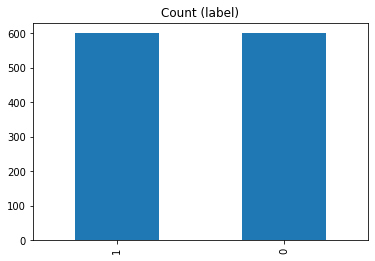

In [ ]:

count_class_0, count_class_1 = df2.label.value_counts()

# Divide by class
print('Initially:')
print(df2.label.value_counts())
df2_class_0 = df2[df2['label'] == 0]
df2_class_1 = df2[df2['label'] == 1]
df2_class_1_over = df2_class_1.sample(count_class_0, replace=True)
df2 = pd.concat([df2_class_0, df2_class_1_over], axis=0)

print('Random over-sampling:')
print(df2.label.value_counts())

df2.label.value_counts().plot(kind='bar', title='Count (label)');


**Detect** **and** **drop** **outliers**

In [ ]:
def detect_outliers(df2,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(f2[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df2[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df2[(df2[col] < Q1 - outlier_step) | (df2[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

    # detect outliers from Features
    Outliers_to_drop = detect_outliers(train,2,Features)
    # Drop outliers
    train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [ ]:
Features= (['Late_2', 'Late_1', 'days_late_Sum', 'Eta',
       'p_limit', 'curr_remaining', 'max_bal', 'Alpha', 'Beta','normal_payment',
        'Delta', 'Zeta', 'Theta', 'Iota', 'Kappa','Late_3','Epsilon','Gamma',
       'Lambda', 'omikron'])
y_train=df2.label
x_train= df2[Features]


In [ ]:
test_data=pd.read_csv('/content/user_data_testing.csv')
df_test = pd.merge(phf,test_data,on = 'id')

df_test.p_limit.fillna(value = df_test.p_limit.mean(),inplace = True)
df_test.Beta.fillna(value = df_test.Beta.mean(),inplace = True)

id_test = df_test.id
df_test = df_test.drop('id',axis = 'columns')
df_test=df_test[Features]

**Train Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(n_estimators=800,min_samples_split=2,max_depth=10)
model1.fit(x_train,y_train)
y_pred=model1.predict(df_test)
model1

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
submission = pd.DataFrame({'label':y_pred,'id':id_test})
submission.shape
submission.to_csv('cass_final.csv',index=False)
print("Saved the submission file")

Saved the submission file
